In [1]:
import anndata as ad
import pandas as pd
import scanpy as sc
import scvi
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import umap.umap_ as UMAP
import os
import torch
from IPython.core.debugger import set_trace
from tqdm import tqdm
import pickle

/opt/micromamba/envs/comfyui/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/opt/micromamba/envs/comfyui/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [2]:
adata = ad.read_h5ad("scRNA-seqProcessedLabelledObject.h5ad")

#### Remove junk

In [3]:
# Identify mitochondrial and ribosomal genes
mito_genes = adata.var_names.str.startswith("MT-")  # Mitochondrial genes
ribo_genes = adata.var_names.str.startswith(("RPS", "RPL"))  # Ribosomal genes

# Combine boolean masks
remove_genes = mito_genes | ribo_genes
print(adata.var_names[remove_genes])

# Filter the AnnData object (keep only non-mitochondrial and non-ribosomal genes)
print(len(adata.var_names))
adata = adata[:, ~remove_genes]
print(len(adata.var_names))

Index(['RPL22', 'RPL11', 'RPS6KA1', 'RPS8', 'RPL5', 'RPS27', 'RPS6KC1', 'RPS7',
       'RPS27A', 'RPL31',
       ...
       'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB',
       'RPL36A-HNRNPH2', 'RPS4Y2', 'RPS6KA6'],
      dtype='object', length=114)
22091
21977


In [71]:
cell_types = {
    'T cells': [
        'CD4_TEM_ANXA1',
        'CD8_TEM_GNLY',
        'CD4_TEM_GNLY',
        'CD8_TEM_CMC1',
        'CD4_TCM_AQP3',
        'CD4_Naive_CCR7',
        'CD8_MAIT_SLC4A10',
        'CD8_Naive_LEF1',
        'CD4_Treg_FOXP3',
        'CD8_TCM_HAVCR2',
        'CD8_TEM_ZNF683',
        'gdT',
    ],
    'B cells': [
        'B_Memory',
        'B_Naive',
        'B_Atypical_Memory',
        'B_BCR_GNLY',
        'Plasma cell',
    ],
    'NK cells': [
        'NK_CD56_Dim',
        'NK_CD56_Bright',
        'NK_Proliferating',
    ],
    'Myeloid cells': [
        'Monocytes_CD14',
        'Monocytes_CD16',
        'pDC',
        'mDC',
    ]
}

flat_cell_types = []
for k,v in cell_types.items():
    flat_cell_types.extend(v)

In [5]:
subsets = {cell_type: adata[adata.obs['secondary_type'] == cell_type] for cell_type in flat_cell_types}
samples = adata.obs['sampleName'].unique()

#### Synthesize pseudobulk data with CP10k normalization

In [ ]:
pseudobulk = {}
significantly_expressed_genes = {}

for cell_type, subset in tqdm(subsets.items()):
    cell_type_pseudobulk = []
    for sample in tqdm(samples):
        sample_subset = subset[subset.obs['sampleName'] == sample].X
        cell_type_pseudobulk.append(np.array((sample_subset.sum(axis=0) / sample_subset.sum()) * 1e4))
    cell_type_pseudobulk = np.stack(cell_type_pseudobulk).squeeze()
    seg = (cell_type_pseudobulk > 1).sum(axis=0) > 2
    cell_type_pseudobulk = cell_type_pseudobulk[:, seg]

    significantly_expressed_genes[cell_type] = seg
    pseudobulk[cell_type] = cell_type_pseudobulk

pickle.dump({'pseudobulk': pseudobulk, 'significantly_expressed_genes': significantly_expressed_genes}, open('pseudobulk_data.pkl', 'wb'))


# Swap comments in this cell when running this notebook again - it will load cached pseudobulk data instead of synthesizing it de novo

# saved_res = pickle.load(open('pseudobulk_data.pkl', 'rb'))
# pseudobulk = saved_res['pseudobulk']
# significantly_expressed_genes = saved_res['significantly_expressed_genes']

#### Group samples by age group

In [7]:
from scipy.stats import kruskal

sample_ids_by_age_group = []

age_groups = adata.obs['eight_group'].unique()
age_groups = list(age_groups)
age_groups.remove('pregnant')
age_groups

for group in age_groups:
    sample_names = adata[adata.obs['eight_group'] == group].obs['sampleName'].unique()
    sample_ids = np.argwhere(np.in1d(samples, sample_names)).flatten()
    sample_ids_by_age_group.append(sample_ids)

/tmp/ipykernel_8663/1458117104.py:12: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  sample_ids = np.argwhere(np.in1d(samples, sample_names)).flatten()
/tmp/ipykernel_8663/1458117104.py:12: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  sample_ids = np.argwhere(np.in1d(samples, sample_names)).flatten()
/tmp/ipykernel_8663/1458117104.py:12: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  sample_ids = np.argwhere(np.in1d(samples, sample_names)).flatten()
/tmp/ipykernel_8663/1458117104.py:12: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  sample_ids = np.argwhere(np.in1d(samples, sample_names)).flatten()
/tmp/ipykernel_8663/1458117104.py:12: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  sample_ids = np.argwhere(np.in1d(samples, sample_names)).flatten()
/tmp/ipykernel_8663/1458117104.py:12: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  sample_ids = np.argwhere(np.in1d(sa

#### Identify DEGs by Kruskal-Wallis test

In [8]:
from collections import defaultdict

deg_names = defaultdict(list)
deg_ids = defaultdict(list)

for cell_type, pseudobulk_exp in pseudobulk.items():
    for gene_id in range(pseudobulk_exp.shape[1]):
        gene_exp = pseudobulk_exp[:, gene_id]
        group_gene_exp = [gene_exp[group_sample_ids] for group_sample_ids in sample_ids_by_age_group]
        h, p = kruskal(*group_gene_exp)
        
        if p < 1e-3:
            gene_name = adata.var_names[significantly_expressed_genes[cell_type]][gene_id]
            deg_names[cell_type].append(gene_name)
            deg_ids[cell_type].append(gene_id)

In [75]:
num_degs = {cell_type: {subtype: len(deg_names[subtype]) for subtype in subtypes} for cell_type, subtypes in cell_types.items()}
num_degs

{'T cells': {'CD4_TEM_ANXA1': 252,
  'CD8_TEM_GNLY': 150,
  'CD4_TEM_GNLY': 0,
  'CD8_TEM_CMC1': 256,
  'CD4_TCM_AQP3': 482,
  'CD4_Naive_CCR7': 496,
  'CD8_MAIT_SLC4A10': 0,
  'CD8_Naive_LEF1': 346,
  'CD4_Treg_FOXP3': 104,
  'CD8_TCM_HAVCR2': 19,
  'CD8_TEM_ZNF683': 0,
  'gdT': 0},
 'B cells': {'B_Memory': 0,
  'B_Naive': 0,
  'B_Atypical_Memory': 88,
  'B_BCR_GNLY': 0,
  'Plasma cell': 0},
 'NK cells': {'NK_CD56_Dim': 282, 'NK_CD56_Bright': 42, 'NK_Proliferating': 0},
 'Myeloid cells': {'Monocytes_CD14': 113,
  'Monocytes_CD16': 30,
  'pDC': 16,
  'mDC': 0}}

#### Plot DEGs by cell subtype

/tmp/ipykernel_8663/1083860664.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=labels, y=values, palette=subset_colors)


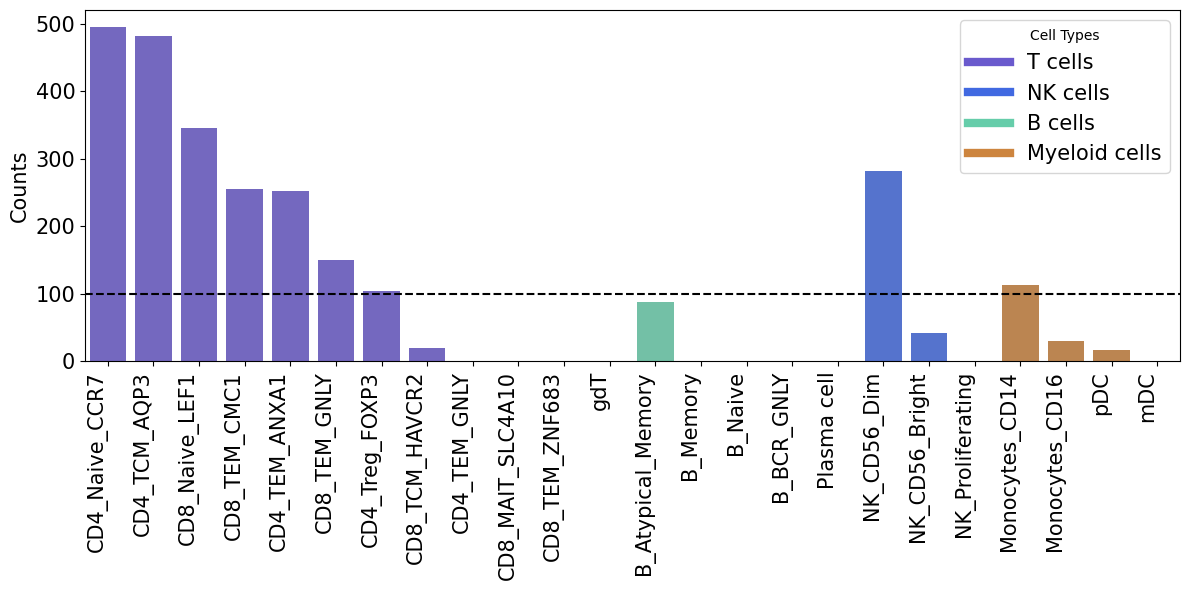

In [87]:
# Define colors for each subset
colors = {
    "T cells": "#6A5ACD",
    "NK cells": "#4169E1",
    "B cells": "#66CDAA",
    "Myeloid cells": "#CD853F"
}

# Process and sort data
sorted_data = {}
for subset, values in num_degs.items():
    sorted_data[subset] = dict(sorted(values.items(), key=lambda item: item[1], reverse=True))

# Flatten data into lists
labels, values, subset_colors = [], [], []
for subset, items in sorted_data.items():
    labels.extend(items.keys())
    values.extend(items.values())
    subset_colors.extend([colors[subset]] * len(items))

# Plot
plt.figure(figsize=(12, 6))
bars = sns.barplot(x=labels, y=values, palette=subset_colors)

# Rotate x labels for readability
plt.xticks(rotation=90, ha="right", fontsize=15)

# Add legend
legend_patches = [plt.Line2D([0], [0], color=color, lw=6, label=subset) for subset, color in colors.items()]
plt.legend(handles=legend_patches, title="Cell Types", loc="upper right", fontsize=15)

# Add a reference line (optional)
plt.axhline(y=100, color="black", linestyle="--")
plt.rc('ytick',labelsize=15)
# Set labels
plt.ylabel("Counts", fontsize=15)
plt.tight_layout()
plt.savefig('degs.pdf')

In [17]:
sample_ages = [adata[adata.obs['sampleName'] == sample].obs['age'].unique()[0] for sample in samples]

#### Identify M-DEGs by thresholding absolute value of Spearman Rho at > 0.6 with p < 0.01

In [24]:
from scipy.stats import spearmanr

incr_m_degs = defaultdict(list)
decr_m_degs = defaultdict(list)

for cell_type, pseudobulk_exp in pseudobulk.items():
    cell_type_deg_ids = deg_ids[cell_type]
    cell_type_deg_names = deg_names[cell_type]
    
    for deg_id, deg_name in zip(cell_type_deg_ids, cell_type_deg_names):
        deg_expression = pseudobulk_exp[:, deg_id]
        r = spearmanr(deg_expression, sample_ages)
        pvalue, statistic = r.pvalue, r.statistic
        if pvalue < 1e-2:
            if statistic >= 0.6:
                incr_m_degs[cell_type].append(deg_name)
            elif statistic <= -0.6:
                decr_m_degs[cell_type].append(deg_name)

In [47]:
incr_m_degs_flat = list(set([gene for subtype, genes in incr_m_degs.items() for gene in genes]))
incr_m_degs_flat

['CTSA',
 'IDS',
 'TIGIT',
 'TENT5C',
 'VOPP1',
 'F2R',
 'CRIP2',
 'TSHZ2',
 'SELENOM',
 'NBPF15',
 'SPART',
 'TPD52',
 'PCSK1N',
 'EMB',
 'SBDS',
 'KIF21A',
 'EDA',
 'SORBS3',
 'SESN3',
 'SH3BP5',
 'RNF19A',
 'CLSTN1',
 'STAT4',
 'IKZF3',
 'CDKN1B',
 'HLA-DPA1',
 'HLA-DPB1',
 'GCHFR',
 'GABARAPL1',
 'GBP5',
 'AHNAK',
 'SYNE2',
 'DHRS7',
 'SVIP',
 'CAPN2',
 'LINC00402',
 'XPC',
 'CRTAP',
 'PFKP',
 'CST7',
 'CAST']

In [49]:
decr_m_degs_flat = list(set([gene for subtype, genes in decr_m_degs.items() for gene in genes]))
decr_m_degs_flat

['BNIP3L',
 'PLIN2',
 'PCNT',
 'BZW2',
 'CCT2',
 'CCDC28B',
 'FAM32A',
 'SLC25A5',
 'SERBP1',
 'AOAH',
 'ING4',
 'NSMCE1',
 'SERPINF1',
 'GNG10',
 'MZB1',
 'TCEAL8',
 'TIMM8B',
 'PLAC8',
 'ID2',
 'AC093157.1',
 'BEX4',
 'ZNF22',
 'CDCA7L',
 'TM2D3',
 'LAMTOR5',
 'DENND2D',
 'NREP',
 'HPGD',
 'ABRACL',
 'SH2D1A',
 'CD38',
 'FBLN2',
 'SCML4',
 'STMN1',
 'CHI3L2',
 'OLFM2',
 'TIMM13',
 'CARHSP1',
 'TMIGD2',
 'SMC4',
 'SPOP',
 'OCIAD2',
 'SOX4',
 'ILF2',
 'SNRPE',
 'LIMS2',
 'TNFRSF1A',
 'GNG2',
 'SIRPG',
 'OSTC',
 'GPA33',
 'GPX7',
 'TSPAN14',
 'RBM4',
 'IL16',
 'MRFAP1L1',
 'ADSL',
 'GGCT',
 'LRRN3',
 'CCR7',
 'DECR1',
 'PSMB7',
 'CD40LG',
 'GIMAP6']

#### Identify common M-DEGs that are present in several cell subtypes

In [67]:
common_incr_m_degs = defaultdict(lambda: 0)
for _, genes in incr_m_degs.items():
    for gene in genes:
        common_incr_m_degs[gene] += 1

common_incr_m_degs = {gene: count for gene, count in common_incr_m_degs.items() if count > 1}
common_incr_m_degs

{'EMB': 2, 'HLA-DPB1': 2, 'SYNE2': 4, 'AHNAK': 2, 'SVIP': 2, 'SESN3': 2}

In [68]:
common_decr_m_degs = defaultdict(lambda: 0)
for _, genes in decr_m_degs.items():
    for gene in genes:
        common_decr_m_degs[gene] += 1
        
common_decr_m_degs = {gene: count for gene, count in common_decr_m_degs.items() if count > 1}
common_decr_m_degs

{'BZW2': 3,
 'CCT2': 3,
 'TMIGD2': 2,
 'OLFM2': 3,
 'PLAC8': 4,
 'GPX7': 2,
 'DENND2D': 4,
 'GPA33': 2,
 'HPGD': 2,
 'NREP': 3,
 'SOX4': 3,
 'CDCA7L': 3,
 'LRRN3': 3,
 'ZNF22': 4,
 'NSMCE1': 2,
 'STMN1': 2,
 'CCDC28B': 2,
 'SNRPE': 2,
 'ID2': 2,
 'OCIAD2': 2,
 'OSTC': 2,
 'ABRACL': 2,
 'GGCT': 2,
 'BNIP3L': 2,
 'TIMM8B': 2}

/tmp/ipykernel_8663/4252888617.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette=colors)


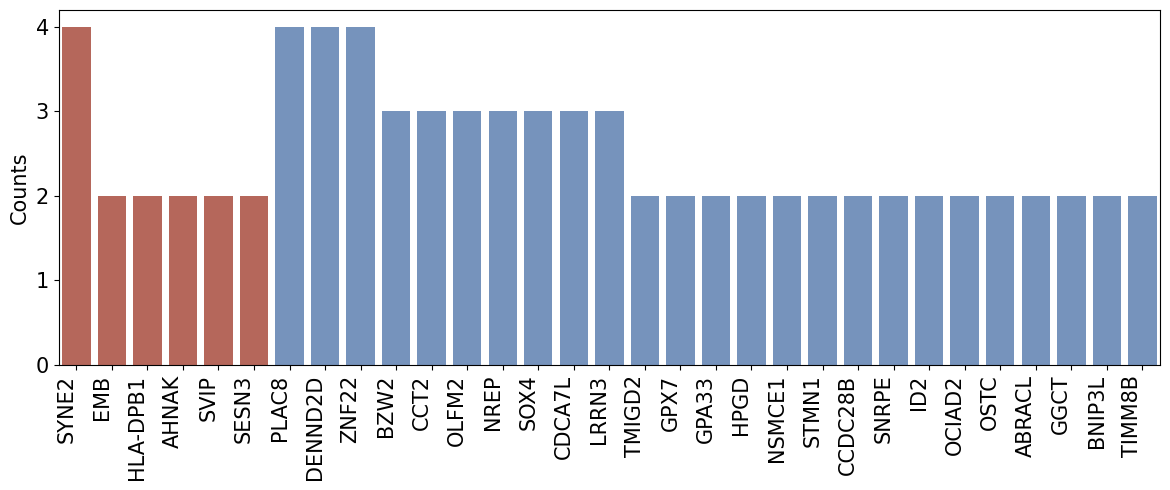

In [86]:
# Sort each subset in descending order
subset1_sorted = dict(sorted(common_incr_m_degs.items(), key=lambda item: item[1], reverse=True))
subset2_sorted = dict(sorted(common_decr_m_degs.items(), key=lambda item: item[1], reverse=True))

# Combine keys and values
labels = list(subset1_sorted.keys()) + list(subset2_sorted.keys())
values = list(subset1_sorted.values()) + list(subset2_sorted.values())

# Define colors for subsets
colors = ["#c45c4c"] * len(subset1_sorted) + ["#6b91c7"] * len(subset2_sorted)

# Plot
plt.figure(figsize=(12, 5))
sns.barplot(x=labels, y=values, palette=colors)

# Rotate x labels for readability
plt.xticks(rotation=90, ha="right", fontsize=15)

plt.rc('ytick',labelsize=15)

# Set labels
plt.ylabel("Counts", fontsize=15)
plt.tight_layout()
plt.savefig('common_mdegs.pdf')